<a href="https://colab.research.google.com/github/sobti/TSAI/blob/master/S10/resnet_model_album_cam__LR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Mounting Google Colab and importing generic Packages
import torchvision
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from albumentations.pytorch import ToTensor
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from google.colab import drive
import os
import sys
from tqdm import tqdm
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

import torchvision
import torch
import albumentations
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose,Cutout)

drive.mount('/content/gdrive/')
sys.path.append('/content/gdrive/My Drive/Colab Notebooks\resnet')
os.chdir('/content/gdrive/My Drive/Colab Notebooks/resnet')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
#importing self-created packages:
import test_train1 as t                                                         #import train - test module .This is class to train and evaluate the model
import load as ld                                                               #dataloader
import mod_summ as m                                                            #Getting model summary package
import Basic_Block as bb                                                        #Getting Classes for Resnet and Basic Block
import album_cutout as al                                                       #Getting albumentation module
import override_album as oa                                                     # overriding the albumentation class
import GradCm as gd                                                             #Grad Cam Module
import plot_cam   as pt                                                         #Plotting Image with Gradcam
import lr_update  as lr                                                         #exponential LR update


In [0]:
# RESNET BLOCK
 def ResNet18():
  return bb.ResNet(bb.BasicBlock, [2,2,2,2])
def test():  
  net = ResNet18()
  y = net(torch.randn(1,3,32,32))
  return net

In [0]:
net=test().to('cuda') 
#net=test().to('cpu')
#net=test()
#net=test()#Net - Model to CUDA 
m.summ_print(net,(3,32,32))# Model summary.

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [0]:
train_transforms,test_transforms=al.album_transform(albumentations)             #Albumentation class 

In [0]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=None)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=None)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
# Initialize the dataset, pass the augmentation pipeline as an argument to init function
train_ds = oa.PyTorchImageDataset(image=trainset, augmentations=train_transforms)
test_ds =  oa.PyTorchImageDataset(image=testset, augmentations=test_transforms)

In [0]:
batch_size=64
trainloader,testloader=ld.load_test_train(batch_size,train_ds,test_ds,torchvision,torch)

In [0]:
def range_test(end_lr=10,num_iter=100,step_mode="exp", smooth_f=0.05, diverge_th=5):
        if step_mode.lower() == "exp":
            lr_schedule = lr.ExponentialLR(optimizer, end_lr, num_iter)
        elif step_mode.lower() == "linear":
            lr_schedule = lr.LinearLR(optimizer, end_lr, num_iter)
        else:
            raise ValueError("expected one of (exp, linear), got {}".format(step_mode))

        if smooth_f < 0 or smooth_f >= 1:
            raise ValueError("smooth_f is outside the range [0, 1[")
        return lr_schedule

In [0]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []
optimizer = optim.SGD(net.parameters(),lr=0.0000000001)                           # start LR is 0.0001
criterion=nn.CrossEntropyLoss()
lr_schedule=range_test(end_lr=10,num_iter=100,step_mode="exp",smooth_f=0.04,diverge_th=5)
best_loss = None
diverge_th=50
num_iter=100
smooth_f=0.05
#scheduler=StepLR(optimizer,step_size=5,gamma=0.1)
#optimizer=optim.Adam(model.parameters(), lr=0.045, betas=(0.9, 0.999), eps=1e-08, amsgrad=False)
device='cuda'
#device='cpu'
best_lr,best_loss,history=t.train(net, device, trainloader,lr_schedule,optimizer,train_losses,train_acc,tqdm,criterion,smooth_f,diverge_th)

 14%|█▎        | 106/782 [00:04<00:28, 24.02it/s]

Stopping early, the loss has diverged


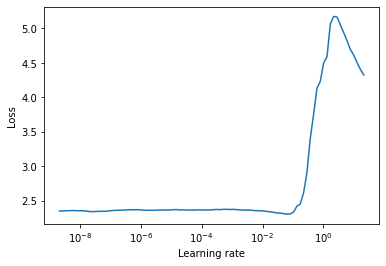

In [0]:
import plot_lr as pltr
ax=pltr.plot(history,plt) 
ax # PLot the LR graph       

In [0]:
print("The best learning rate obtained is ",best_lr)

The best learning rate obtained is  0.0630957344480194


In [0]:
def ResNet18():
  return bb.ResNet(bb.BasicBlock, [2,2,2,2])
def test():  
  net = ResNet18()
  y = net(torch.randn(1,3,32,32))
  return net

In [0]:
import train_test_model_resnet18_missclass as t1                                   #import train - test module .This is class to train and evaluate the model
train_losses = []
test_acc = []
test_losses = []
train_acc = []
train_loss_graph=[]
train_acc_graph=[]
test_acc_graph=[]
test_loss_graph=[]
optimizer = optim.SGD(net.parameters(),lr=best_lr,weight_decay=0.0020,momentum=0.90)
criterion=nn.CrossEntropyLoss()
scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1,patience=2,min_lr=0.00001)
#scheduler=StepLR(optimizer,step_size=5,gamma=0.1)
#optimizer=optim.Adam(model.parameters(), lr=0.045, betas=(0.9, 0.999), eps=1e-08, amsgrad=False)
EPOCHS = 50
device='cuda'
#device='cpu'
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_loss,train_acc1=t1.train(net, device, trainloader, optimizer, epoch,train_losses,train_acc,tqdm,criterion)
    train_loss_graph.append(train_loss)
    train_acc_graph.append(train_acc1)
    test_loss,test_acc1=t1.test(net, device, testloader,test_losses,test_acc,tqdm,criterion,torch)
    test_loss_graph.append(test_loss)
    test_acc_graph.append(test_acc1)
    scheduler.step(test_loss)
    

  0%|          | 0/782 [00:00<?, ?it/s]

EPOCH: 0


Loss=193.25128173828125 Batch_id=781 Accuracy=13.04: 100%|██████████| 782/782 [00:32<00:00, 24.11it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6817, Accuracy: 1291/10000 (12.91%)

EPOCH: 1


Loss=2.56166410446167 Batch_id=781 Accuracy=16.99: 100%|██████████| 782/782 [00:32<00:00, 23.98it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0350, Accuracy: 2074/10000 (20.74%)

EPOCH: 2


Loss=1.9318939447402954 Batch_id=781 Accuracy=20.05: 100%|██████████| 782/782 [00:32<00:00, 24.11it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0333, Accuracy: 2361/10000 (23.61%)

EPOCH: 3


Loss=1.9464834928512573 Batch_id=781 Accuracy=23.59: 100%|██████████| 782/782 [00:32<00:00, 24.16it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0311, Accuracy: 2706/10000 (27.06%)

EPOCH: 4


Loss=1.9604865312576294 Batch_id=781 Accuracy=28.44: 100%|██████████| 782/782 [00:32<00:00, 24.11it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0294, Accuracy: 3280/10000 (32.80%)

EPOCH: 5


Loss=1.9190638065338135 Batch_id=781 Accuracy=34.04: 100%|██████████| 782/782 [00:32<00:00, 24.10it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 3738/10000 (37.38%)

EPOCH: 6


Loss=1.609800934791565 Batch_id=781 Accuracy=37.59: 100%|██████████| 782/782 [00:32<00:00, 24.18it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 4043/10000 (40.43%)

EPOCH: 7


Loss=1.5491881370544434 Batch_id=781 Accuracy=40.72: 100%|██████████| 782/782 [00:32<00:00, 24.15it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 4523/10000 (45.23%)

EPOCH: 8


Loss=1.732351303100586 Batch_id=781 Accuracy=45.00: 100%|██████████| 782/782 [00:32<00:00, 24.22it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 3945/10000 (39.45%)

EPOCH: 9


Loss=1.3377474546432495 Batch_id=781 Accuracy=48.45: 100%|██████████| 782/782 [00:32<00:00, 24.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 4966/10000 (49.66%)

EPOCH: 10


Loss=1.0344585180282593 Batch_id=781 Accuracy=52.03: 100%|██████████| 782/782 [00:32<00:00, 24.16it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 5446/10000 (54.46%)

EPOCH: 11


Loss=2.014446258544922 Batch_id=781 Accuracy=54.38: 100%|██████████| 782/782 [00:32<00:00, 24.29it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 5600/10000 (56.00%)

EPOCH: 12


Loss=1.0944870710372925 Batch_id=781 Accuracy=56.22: 100%|██████████| 782/782 [00:32<00:00, 24.29it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 5851/10000 (58.51%)

EPOCH: 13


Loss=1.0961225032806396 Batch_id=781 Accuracy=56.98: 100%|██████████| 782/782 [00:32<00:00, 24.37it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 5466/10000 (54.66%)

EPOCH: 14


Loss=1.089148998260498 Batch_id=781 Accuracy=57.46: 100%|██████████| 782/782 [00:32<00:00, 24.35it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 6316/10000 (63.16%)

EPOCH: 15


Loss=1.1042793989181519 Batch_id=781 Accuracy=57.95: 100%|██████████| 782/782 [00:32<00:00, 24.37it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0149, Accuracy: 6708/10000 (67.08%)

EPOCH: 16


Loss=1.3405003547668457 Batch_id=781 Accuracy=58.08: 100%|██████████| 782/782 [00:32<00:00, 24.40it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 5106/10000 (51.06%)

EPOCH: 17


Loss=1.0275373458862305 Batch_id=781 Accuracy=58.69: 100%|██████████| 782/782 [00:32<00:00, 24.40it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0154, Accuracy: 6540/10000 (65.40%)

EPOCH: 18


Loss=0.8341668844223022 Batch_id=781 Accuracy=59.31: 100%|██████████| 782/782 [00:31<00:00, 24.57it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 5838/10000 (58.38%)

EPOCH: 19


Loss=0.7858626842498779 Batch_id=781 Accuracy=68.82: 100%|██████████| 782/782 [00:32<00:00, 24.36it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0097, Accuracy: 7866/10000 (78.66%)

EPOCH: 20


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0091, Accuracy: 7975/10000 (79.75%)

EPOCH: 21


Loss=1.0965473651885986 Batch_id=781 Accuracy=73.48: 100%|██████████| 782/782 [00:32<00:00, 24.43it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0093, Accuracy: 7942/10000 (79.42%)

EPOCH: 22


Loss=0.9155294299125671 Batch_id=781 Accuracy=74.25: 100%|██████████| 782/782 [00:32<00:00, 24.40it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0089, Accuracy: 8038/10000 (80.38%)

EPOCH: 23


Loss=0.8934191465377808 Batch_id=781 Accuracy=74.74: 100%|██████████| 782/782 [00:32<00:00, 24.36it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0094, Accuracy: 7984/10000 (79.84%)

EPOCH: 24


Loss=0.6088722944259644 Batch_id=781 Accuracy=75.38: 100%|██████████| 782/782 [00:32<00:00, 24.28it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0084, Accuracy: 8192/10000 (81.92%)

EPOCH: 25


Loss=1.0721458196640015 Batch_id=781 Accuracy=75.83: 100%|██████████| 782/782 [00:31<00:00, 24.48it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0091, Accuracy: 8041/10000 (80.41%)

EPOCH: 26


Loss=0.4830375909805298 Batch_id=781 Accuracy=75.76: 100%|██████████| 782/782 [00:31<00:00, 24.45it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0091, Accuracy: 8107/10000 (81.07%)

EPOCH: 27


Loss=0.8484975099563599 Batch_id=781 Accuracy=76.41: 100%|██████████| 782/782 [00:31<00:00, 24.58it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0099, Accuracy: 7918/10000 (79.18%)

EPOCH: 28


Loss=0.7020958662033081 Batch_id=781 Accuracy=80.60: 100%|██████████| 782/782 [00:31<00:00, 24.49it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0065, Accuracy: 8607/10000 (86.07%)

EPOCH: 29


Loss=0.5349414348602295 Batch_id=781 Accuracy=82.05: 100%|██████████| 782/782 [00:31<00:00, 24.46it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0062, Accuracy: 8677/10000 (86.77%)

EPOCH: 30


Loss=0.44774168729782104 Batch_id=781 Accuracy=82.84: 100%|██████████| 782/782 [00:31<00:00, 24.52it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0062, Accuracy: 8686/10000 (86.86%)

EPOCH: 31


Loss=1.2305517196655273 Batch_id=781 Accuracy=83.27: 100%|██████████| 782/782 [00:31<00:00, 24.44it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0061, Accuracy: 8712/10000 (87.12%)

EPOCH: 32


Loss=0.45630937814712524 Batch_id=781 Accuracy=83.67: 100%|██████████| 782/782 [00:31<00:00, 24.53it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0060, Accuracy: 8711/10000 (87.11%)

EPOCH: 33


Loss=0.46138256788253784 Batch_id=781 Accuracy=83.93: 100%|██████████| 782/782 [00:32<00:00, 24.29it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0058, Accuracy: 8781/10000 (87.81%)

EPOCH: 34


Loss=0.40678176283836365 Batch_id=781 Accuracy=84.87: 100%|██████████| 782/782 [00:31<00:00, 24.56it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 8735/10000 (87.35%)

EPOCH: 35


Loss=0.3506314754486084 Batch_id=781 Accuracy=84.98: 100%|██████████| 782/782 [00:31<00:00, 24.47it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0058, Accuracy: 8738/10000 (87.38%)

EPOCH: 36


Loss=0.39598172903060913 Batch_id=781 Accuracy=85.10: 100%|██████████| 782/782 [00:31<00:00, 24.53it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0057, Accuracy: 8761/10000 (87.61%)

EPOCH: 37


Loss=0.6048004031181335 Batch_id=781 Accuracy=85.36: 100%|██████████| 782/782 [00:31<00:00, 24.44it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0057, Accuracy: 8786/10000 (87.86%)

EPOCH: 38


Loss=0.456407368183136 Batch_id=781 Accuracy=85.61: 100%|██████████| 782/782 [00:31<00:00, 24.53it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0057, Accuracy: 8794/10000 (87.94%)

EPOCH: 39


Loss=0.23647460341453552 Batch_id=781 Accuracy=86.31: 100%|██████████| 782/782 [00:31<00:00, 24.71it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0056, Accuracy: 8773/10000 (87.73%)

EPOCH: 40


Loss=0.37514814734458923 Batch_id=781 Accuracy=85.91: 100%|██████████| 782/782 [00:31<00:00, 24.54it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0056, Accuracy: 8806/10000 (88.06%)

EPOCH: 41


Loss=0.818047821521759 Batch_id=781 Accuracy=86.20: 100%|██████████| 782/782 [00:31<00:00, 24.58it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0057, Accuracy: 8754/10000 (87.54%)

EPOCH: 42


Loss=0.2004956752061844 Batch_id=781 Accuracy=86.63: 100%|██████████| 782/782 [00:31<00:00, 24.52it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0056, Accuracy: 8780/10000 (87.80%)

EPOCH: 43


Loss=0.5190128087997437 Batch_id=781 Accuracy=86.63: 100%|██████████| 782/782 [00:31<00:00, 24.45it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0056, Accuracy: 8799/10000 (87.99%)

EPOCH: 44


Loss=0.29439693689346313 Batch_id=781 Accuracy=87.58: 100%|██████████| 782/782 [00:31<00:00, 24.56it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 8839/10000 (88.39%)

EPOCH: 45


Loss=0.6226805448532104 Batch_id=781 Accuracy=88.15: 100%|██████████| 782/782 [00:32<00:00, 24.31it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0054, Accuracy: 8832/10000 (88.32%)

EPOCH: 46


Loss=0.08518341183662415 Batch_id=781 Accuracy=87.96: 100%|██████████| 782/782 [00:31<00:00, 24.47it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 8846/10000 (88.46%)

EPOCH: 47


Loss=0.7256094217300415 Batch_id=781 Accuracy=88.43: 100%|██████████| 782/782 [00:32<00:00, 24.39it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 8867/10000 (88.67%)

EPOCH: 48


Loss=0.25826296210289 Batch_id=781 Accuracy=88.36: 100%|██████████| 782/782 [00:32<00:00, 24.41it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 8871/10000 (88.71%)

EPOCH: 49


Loss=0.28414949774742126 Batch_id=781 Accuracy=88.34: 100%|██████████| 782/782 [00:32<00:00, 24.20it/s]



Test set: Average loss: 0.0053, Accuracy: 8854/10000 (88.54%)



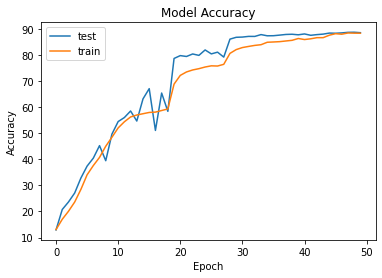

In [0]:
plt.plot(test_acc_graph)                
plt.plot(train_acc_graph)        
plt.title("Model Accuracy")          
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['test','train'] ,loc='upper left')
plt.show()  
                                            

In [0]:
cam2=[]          
data2=[]
k=[]
dat=[]
number=0
p=[]
l=[]
data2=[]
for im in range(25):
  
  dat1,label = next(iter(testloader))
  dat1=dat1.to('cuda')
  output=net(dat1)
  pred = output.argmax(dim=1, keepdim=True)
  
  for i in range(label.size()[0]):
   if pred[i].item() != label[i].item():
    p.append(pred[i].item()) 
    l.append(label[i].item()) 
    label1=label[i]
    data1=dat1[i]
    data2.append(dat1[i].to('cpu'))
    label1=label1.unsqueeze(0) 
    Gd1=gd.GradCm()
    cam1=Gd1.img(data1,label1,net)
    cam2.append(cam1) 
    number = len(cam2)
    if number >= 25:
        print(number)
        break
  else:
   continue
  break 

25


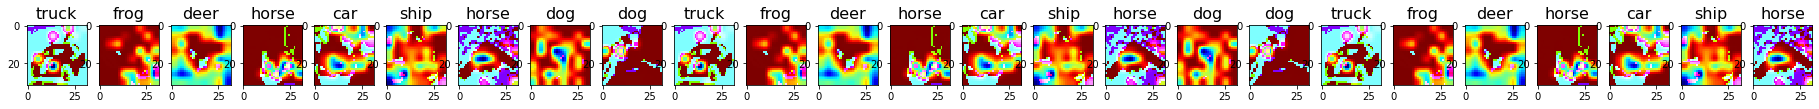

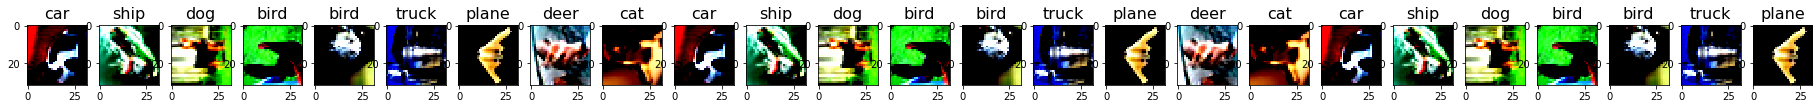

In [0]:
plott=pt.Plot()
#l=l.to('cpu')
#data2=data2.to('cpu')
plott.fig(data2,cam2,l,p)
